In [1]:
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import glob
import zipfile
import numpy as np
import json,os
from jarvis.db.jsonutils import loadjson
from collections import defaultdict
import pandas as pd
from sklearn.metrics import mean_absolute_error, accuracy_score



def get_metric_value(
    submod="",
    csv_path="",
    dataset="",
    prop="",
    data_split="",
    method="",
    metric="",
    bench_name="",
):
    results = {}
    results["method"] = method
    results["submod"] = submod
    results["dataset"] = dataset
    results["prop"] = prop
    results["data_split"] = data_split
    results["csv_path"] = csv_path
    results["metric"] = metric
    csv_data = pd.read_csv(csv_path, sep=",")
    meta_path = csv_path.split("/")
    meta_path[-1] = "metadata.json"
    meta_path = "/".join(meta_path)
    meta_data = loadjson(meta_path)
    results["model_name"] = meta_data["model_name"]
    results["team_name"] = meta_data["team_name"]
    results["date_submitted"] = meta_data["date_submitted"]
    results["project_url"] = meta_data["project_url"]
    results["num_entries"] = len(csv_data)
    results["github_url"] = (
        "https://github.com/usnistgov/jarvis_leaderboard/tree/main/jarvis_leaderboard/benchmarks/"
        + bench_name
    )  # meta_path.split('metadata.json')[0]

    # print("meta_path", meta_data)
    # meta_data=loadjson()
    # print("csv_data", csv_path)
    # dataset with actual values
    temp = dataset + "_" + prop + ".json"
    # print ('json temp',temp)
    temp2 = temp + ".zip"
    fname = os.path.join("dataset", method, submod, temp2)
    fname2 = os.path.join(root_dir, fname)

    z = zipfile.ZipFile(fname2)
    json_data = json.loads(z.read(temp))

    # json_data = loadjson(os.path.join(root_dir, fname))
    actual_data_json = json_data[data_split]
    if "val" in json_data:  # sometimes just train-test
        data_size = (
            len(json_data["train"])
            + len(json_data["val"])
            + len(json_data["test"])
        )
    else:
        data_size = len(json_data["train"]) + len(json_data["test"])
    # print ('actual_data_json',actual_data_json)
    results["dataset_size"] = data_size
    ids = []
    targets = []
    for i, j in actual_data_json.items():
        ids.append(i)
        targets.append(j)
    mem = {"id": ids, "actual": targets}
    actual_df = pd.DataFrame(mem)
    # print ('actual_df',actual_df)
    # print('csv_data',csv_data)
    # actual_df.to_csv('actual_df.csv')
    # csv_data.to_csv('csv_data.csv')
    csv_data["id"] = csv_data["id"].astype(str)
    actual_df["id"] = actual_df["id"].astype(str)
    if len(csv_data) != len(actual_df):
        print("Error", csv_path, len(csv_data), len(actual_df))
        errors.append(csv_path)

    df = pd.merge(csv_data, actual_df, on="id")
    # print('csv',csv_path)
    # print ('df',df)
    # print('csv_data',csv_data)
    # print('actual_df',actual_df)
    results["res"] = "na"
    results["df"] = df
    
    if metric == "mae":
        res = round(mean_absolute_error(df["actual"], df["prediction"]), 3)
        results["res"] = res
        if "qm9_std_jctc" in csv_path:
            # print('scaling[dataset][prop],',scaling[dataset][prop])
            res = round(
                scaling[dataset][prop]
                * mean_absolute_error(df["actual"], df["prediction"]),
                3,
            )
            results["res"] = res
            # print(csv_path)
            # print('mae1',mean_absolute_error(csv_data['target'],csv_data['prediction']))
            # print('res',res)
            # print(csv_data)
            # print(actual_df)
            # print()
    if metric == "acc":
        # print("ACC",csv_path)
        # print(df, len(df))
        res = round(accuracy_score(df["actual"], df["prediction"]), 3)
        # print("res", res)
        results["res"] = res
    if metric == "multimae":
        # print("csv multimae", csv_path)
        # print ('df',df)
        maes = []
        for k, v in df.iterrows():
            real = np.array(v["actual"].split(";"), dtype="float")
            # real = np.array(v["target"].split(";"), dtype="float")
            pred = np.array(v["prediction"].split(";"), dtype="float")
            m = mean_absolute_error(real, pred)
            maes.append(m)
            # print('mm',m)
        results["res"] = round(np.array(maes).sum(), 3)
        # print ('df',df)
        # print('csv_data',csv_data)
        # print('actual_df',actual_df)
        # print('res',results['res'])

    return results




def mean_absolute_deviation(data, axis=None):
    """Get Mean absolute deviation."""
    return np.mean(np.absolute(data - np.mean(data, axis)), axis)


info = defaultdict()
id_info = defaultdict()
root_dir='..'
metric_names=[]
scaling = {
    "qm9_std_jctc": {
        "alpha": 8.172947,
        "mu": 1.503449,
        "HOMO": 0.597728,
        "LUMO": 1.274800,
        "gap": 1.284114,
        "R2": 280.472586,
        "ZPVE": 0.901645,
        "U0": 10.322918,
        "U": 10.414332,
        "H": 10.488418,
        "G": 9.497589,
        "Cv": 4.067492,
    }
}
mad_vals=[]
mae_vals=[]
mae_over_mad_vals=[]
mae_model_names=[]
nm_count=0
nm_index=[]


ai_form_en={}
es_kv={}
qc_eig={}
exp_co2={}



for i in glob.glob("../benchmarks/*/*.csv.zip"):

    fname = i.split("/")[-1].split(".csv.zip")[0]
    temp = fname.split("-")
    dataset = temp[3]
    bench_name = i.split("/")[-2]
    prop = temp[2]
    submod = temp[1]
    method = temp[0]
    metric = temp[-1]
    metric_names.append(metric)
    data_split='test'
    json_name = dataset + "_" + prop + ".json"
    json_path = '../dataset/'+method+'/'+submod+'/'+json_name+'.zip'
    z = zipfile.ZipFile(json_path)
    json_data = json.loads(z.read(json_name))
    if dataset not in id_info:
        id_info[dataset]=[]

        
    if "val" in json_data:  # sometimes just train-test
        data_size = (
            len(json_data["train"])
            + len(json_data["val"])
            + len(json_data["test"])
        )
        for m in list(json_data["train"].keys()):
          
                id_info[dataset].append(m)
        for m in list(json_data["val"].keys()):
           
                id_info[dataset].append(m)
        for m in list(json_data["test"].keys()):
            
                id_info[dataset].append(m)
    else:
        data_size = len(json_data["train"]) + len(json_data["test"])
        for m in list(json_data["train"].keys()):
            
                id_info[dataset].append(m)

        for m in list(json_data["test"].keys()):
           
                id_info[dataset].append(m)
    res = get_metric_value(
        submod=submod,
        csv_path=i,
        dataset=dataset,
        prop=prop,
        data_split=data_split,
        method=method,
        metric=metric,
        bench_name=bench_name,
    )
    if i.split('/')[-1]=='AI-SinglePropertyPrediction-formation_energy_peratom-dft_3d-test-mae.csv.zip':
        ai_form_en[bench_name]=res['df']
  
    if i.split('/')[-1]=='ES-SinglePropertyPrediction-bulk_modulus-dft_3d-test-mae.csv.zip':
        es_kv[bench_name]=res['df']
    if i.split('/')[-1]=='QC-EigenSolver-electron_bands_JVASP_816_Al_WTBH-dft_3d-test-multimae.csv.zip':
        qc_eig[bench_name]=res['df']
    if i.split('/')[-1]=='EXP-Spectra-co2_RM_8852-nist_isodb-test-multimae.csv.zip':
        exp_co2[bench_name]=res['df']
        
    if  metric=='mae' and 'JVASP_' not in i:
        if len(json_data["train"])==0:
            tdata=[]
            for m in list(json_data["test"].values()):
                tdata.append(m)    
        else:
            tdata=[]
            for m in list(json_data["train"].values()):
                tdata.append(m)
        
        tdata=np.array(tdata,dtype='float')
        mad=mean_absolute_deviation(tdata)
        mad_vals.append(mad)
        mae=res['res']
        mae_vals.append(mae)
        
        if mad/mae<100:
            nm_count+=1
            mae_over_mad_vals.append(mad/mae)
            nm=i.split('/')[-1].split('-test-mae.csv.zip')[0].split('-')[2].split('_m2cm3')[0].replace('optb88vdw','OPT')
            
            #if mad>100 and 'm2g' not in i:
            if len(mae_vals)%15==0 or 'surface_area_m2cm3' in i or 'n_powerfact' in i:
#                 if 'n_powerfact' in i:
#                     nm_index.append(nm_count-1)
#                 else:
#                 #mae_model_names.append(nm)
                nm_index.append(nm_count)
                mae_model_names.append(nm)
        
                print ('mad',mad,mad/mae,i)
        #break
#     if dataset not in info:
#         info[dataset]=data_size #[data_size]
#     else:
#         info[dataset]=info[dataset]+data_size #.append(data_size)

    #print (dataset,prop,submod,method,json_name)
    #break

mad 260.05808207313635 1.9436910077516245 ../benchmarks/alignn_model/AI-SinglePropertyPrediction-encut-dft_3d-test-mae.csv.zip
mad 17.872272228868823 1.8783260356141693 ../benchmarks/alignn_model/AI-SinglePropertyPrediction-kpoint_length_unit-dft_3d-test-mae.csv.zip
mad 691.5759916864997 1.5635938396571092 ../benchmarks/alignn_model/AI-SinglePropertyPrediction-n_powerfact-dft_3d-test-mae.csv.zip
mad 1.7758403527173154 47.9956852085761 ../benchmarks/alignn_model/AI-SinglePropertyPrediction-optb88vdw_total_energy-dft_3d-test-mae.csv.zip
mad 608.1598193707139 5.6411381286241635 ../benchmarks/alignn_model/AI-SinglePropertyPrediction-surface_area_m2cm3-hmof-test-mae.csv.zip
mad 57.378720481426676 2.3098393978272482 ../benchmarks/cfid/AI-SinglePropertyPrediction-epsx-dft_3d-test-mae.csv.zip
mad 0.5209429405088734 1.3461057894286133 ../benchmarks/cfid/AI-SinglePropertyPrediction-spillage-dft_3d-test-mae.csv.zip
mad 0.9890431960934899 2.436066985451945 ../benchmarks/cfid_chem/AI-SingleProperty

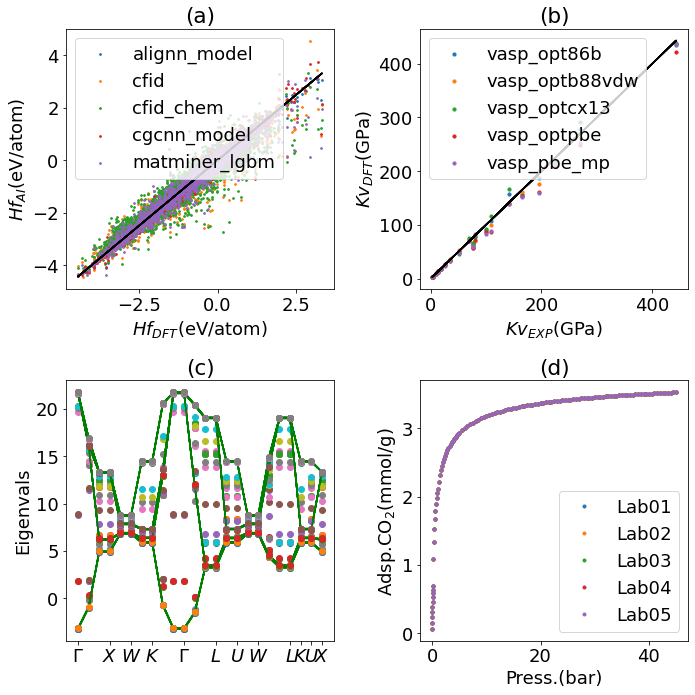

In [11]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

the_grid = GridSpec(2, 2)
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,10))

plt.subplot(the_grid[0, 0])
plt.xlabel('$Hf_{DFT}$(eV/atom)')
plt.ylabel('$Hf_{AI}$(eV/atom)')
plt.title('(a)')
for i,j in ai_form_en.items():
    plt.scatter(j['actual'],j['prediction'],s=3,label=i)
    plt.plot(j['actual'],j['actual'],c='black')
plt.legend()

plt.subplot(the_grid[0, 1])
plt.title('(b)')
plt.ylabel('$Kv_{DFT}$(GPa)')
plt.xlabel('$Kv_{EXP}$(GPa)')
for i,j in es_kv.items():
    plt.scatter(j['actual'],j['prediction'],s=10,label=i)
    plt.plot(j['actual'],j['actual'],c='black')
plt.legend()



plt.subplot(the_grid[1, 0])

for i,j in qc_eig.items():
    actual=np.array(j['actual'].values[0].split(';'),dtype='float').reshape(24,8)
    pred=np.array(j['prediction'].values[0].split(';'),dtype='float').reshape(24,8)
   
    for ii,jj in enumerate(actual.T):
#         if ii==0:
#             plt.plot(jj,'-*',c='g',label='NP')
        plt.plot(jj,'-*',c='g')
        
    for ii,jj in enumerate(pred.T):
#         if ii==0:
#             plt.plot(jj,'*',c='b',label=i.split('qiskit_vqd_SU2_')[1])
        plt.plot(jj,'o',label=i.split('qiskit_vqd_SU2_')[1])
    
kp=[0, 3, 5, 7, 10, 13, 15, 17, 20, 21, 22, 23]
lbls=['$\\Gamma$', '$X$', '$W$', '$K$', '$\\Gamma$', '$L$', '$U$', '$W$', '$L$', '$K$', '$U$', '$X$']
plt.xticks(kp,lbls)
#plt.legend()
plt.title('(c)')
plt.ylabel('Eigenvals')



plt.subplot(the_grid[1, 1])

press=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8, 3, 3.2, 3.4, 3.6, 3.8, 4, 4.2, 4.4, 4.6, 4.8, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19.5, 20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24, 24.5, 25, 25.5, 26, 26.5, 27, 27.5, 28, 28.5, 29, 29.5, 30, 30.5, 31, 31.5, 32, 32.5, 33, 33.5, 34, 34.5, 35, 35.5, 36, 36.5, 37, 37.5, 38, 38.5, 39, 39.5, 40, 40.5, 41, 41.5, 42, 42.5, 43, 43.5, 44, 44.5, 45]

for i,j in exp_co2.items():
    actual=np.array(j['actual'].values[0].split(';'),dtype='float')
    pred=np.array(j['prediction'].values[0].split(';'),dtype='float')
    plt.plot(press,actual,'.',label=i.split('x.')[-1])
plt.legend()
plt.title('(d)')
plt.xlabel('Press.(bar)')
plt.ylabel('Adsp.CO$_2$(mmol/g)')
    
    
plt.tight_layout()
plt.show()
# plt.savefig('results_example.pdf')
# plt.close()

In [ ]:
qiskit_vqd_SU2_

In [196]:
press=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8, 3, 3.2, 3.4, 3.6, 3.8, 4, 4.2, 4.4, 4.6, 4.8, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19.5, 20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24, 24.5, 25, 25.5, 26, 26.5, 27, 27.5, 28, 28.5, 29, 29.5, 30, 30.5, 31, 31.5, 32, 32.5, 33, 33.5, 34, 34.5, 35, 35.5, 36, 36.5, 37, 37.5, 38, 38.5, 39, 39.5, 40, 40.5, 41, 41.5, 42, 42.5, 43, 43.5, 44, 44.5, 45]
len(press)

119

In [193]:
j

,id,prediction,actual
0,RM-8852,2.1619;2.1619;2.1619;2.1619;2.1619;2.1619;2.16...,0.059446;0.146774;0.232756;0.313272;0.387864;0...


In [ ]:
for i,j in qc_eig.items():
    actual=np.array(j['actual'].values[0].split(';'),dtype='float').reshape(24,8)
    pred=np.array(j['prediction'].values[0].split(';'),dtype='float').reshape(24,8)
   
    for ii,jj in enumerate(actual.T):
        if ii==0:
            plt.plot(jj,'-*',c='g',label='NP')
        plt.plot(jj,'-*',c='g')
        
    for ii,jj in enumerate(pred.T):
        if ii==0:
            plt.plot(jj,'*',c='b',label='VQD')
        plt.plot(jj,'*',c='b')
    
kp=[0, 3, 5, 7, 10, 13, 15, 17, 20, 21, 22, 23]
lbls=['$\\Gamma$', '$X$', '$W$', '$K$', '$\\Gamma$', '$L$', '$U$', '$W$', '$L$', '$K$', '$U$', '$X$']
plt.xticks(kp,lbls)
plt.legend()
plt.title('(c)')
plt.ylabel('Eigenvals')

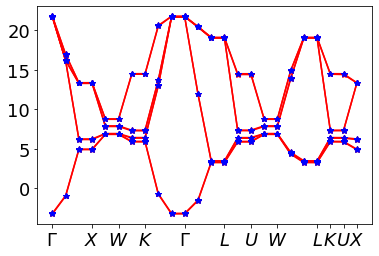

In [178]:

su2=np.array(qc_eig['qiskit_vqd_SU2']['prediction'].values[0].split(';'),dtype='float').reshape(24,8)
for i in su2.T:
    #print (i)
    plt.plot(i,'-*',c='r')
su2=np.array(qc_eig['qiskit_vqd_SU2']['target'].values[0].split(';'),dtype='float').reshape(24,8)
for i in su2.T:
    #print (i)
    plt.plot(i,'*',c='b')
kp=[0, 3, 5, 7, 10, 13, 15, 17, 20, 21, 22, 23]
lbls=['$\\Gamma$', '$X$', '$W$', '$K$', '$\\Gamma$', '$L$', '$U$', '$W$', '$L$', '$K$', '$U$', '$X$']
plt.xticks(kp,lbls)
plt.show()

In [177]:
lbls=['$\\Gamma$',
 '$X$',
 '$W$',
 '$K$',
 '$\\Gamma$',
 '$L$',
 '$U$',
 '$W$',
 '$L$',
 '$K$',
 '$U$',
 '$X$']
lbls


['$\\Gamma$',
 '$X$',
 '$W$',
 '$K$',
 '$\\Gamma$',
 '$L$',
 '$U$',
 '$W$',
 '$L$',
 '$K$',
 '$U$',
 '$X$']

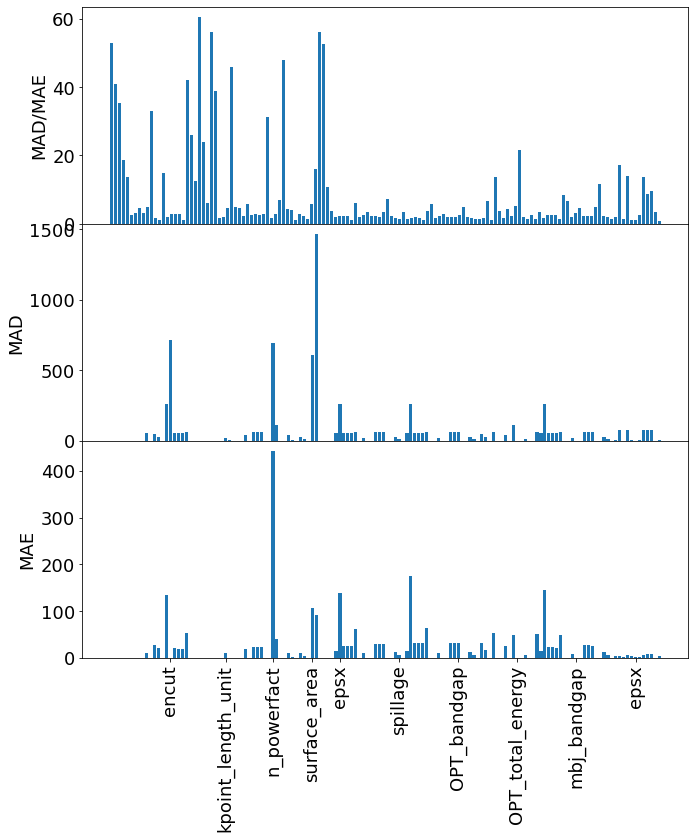

In [97]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

the_grid = GridSpec(3, 1,hspace=0.0)
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,12))

plt.subplot(the_grid[0, 0])
plt.bar(np.arange(len(mae_over_mad_vals)),mae_over_mad_vals)
plt.ylabel('MAD/MAE')
plt.xticks([])


plt.subplot(the_grid[1, 0])
plt.bar(np.arange(len(mad_vals)),mad_vals)

plt.ylabel('MAD')
plt.xticks([])

plt.subplot(the_grid[2, 0])
plt.bar(np.arange(len(mae_vals)),mae_vals)
plt.ylabel('MAE')
# nm_index.pop(3)
# mae_model_names.pop(3)
plt.xticks(nm_index,mae_model_names,rotation=90)

plt.tight_layout()
plt.show()
# plt.savefig('mad_mae.pdf')
# plt.close()




In [99]:
csv_files = [
    'AI-SinglePropertyPrediction-formation_energy_peratom-dft_3d-test-mae.csv.zip'
]
import pandas as pd
for i in glob.glob("../benchmarks/*/*.csv.zip"):
    tmp=i.split('/')[-1]
    if tmp=='AI-SinglePropertyPrediction-formation_energy_peratom-dft_3d-test-mae.csv.zip':
        bench_name = i.split("/")[-2]
        print(i,bench_name)

../benchmarks/alignn_model/AI-SinglePropertyPrediction-formation_energy_peratom-dft_3d-test-mae.csv.zip alignn_model
../benchmarks/cfid/AI-SinglePropertyPrediction-formation_energy_peratom-dft_3d-test-mae.csv.zip cfid
../benchmarks/cfid_chem/AI-SinglePropertyPrediction-formation_energy_peratom-dft_3d-test-mae.csv.zip cfid_chem
../benchmarks/cgcnn_model/AI-SinglePropertyPrediction-formation_energy_peratom-dft_3d-test-mae.csv.zip cgcnn_model
../benchmarks/matminer_lgbm/AI-SinglePropertyPrediction-formation_energy_peratom-dft_3d-test-mae.csv.zip matminer_lgbm


In [78]:
(mae_model_names)[3]

'OPT_total_energy'

In [80]:
nm_index

[15, 29, 41, 51, 58, 73, 88, 103, 118]

In [32]:
from collections import Counter
Counter(metric_names)

Counter({'multimae': 18, 'mae': 674, 'acc': 27})

In [21]:
json_data["test"].values()

dict_values(['2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;2.772;3.03;3.288;3.6065000000000005;3.9250000000000025;4.497;5.069;5.915000000000002;6.761000000000008;8.594000000000008;10.427;14.60900000000002;18.791;20.220999999999993;21.651;22.558500000000002;23.465999999999998;23.051;22.635999999999992;21.665499999999994;20.695;20.000999999999998;19.307;18.798;18.289;17.9465;17.604;17.442999999999998;17.282;17.398;17.514;17.931500000000003;18.349;18.899500000000003;19.45;19.9175;20.385000000000005;20.689500000000002;20.994000000000003;21.218;21.442;21.717000000000002;21.992;22.328000000000003;22.664;23.0865;23.509000000000004;24.052000000000003;24.595000000000006;25.3255;26.056;27.0105;27.965000000000018;28.995000000000008;30.025;30.057;30.089;26.79149999999997;23.494;20.137999999999998;16.782;15.201;13.619999999999983;12.693999999999992;11.768;11.139;10.

nist_isodb 5 1
dft_3d 3092080 55713
alignn_ff_db 1228444 307111
qm9_std_jctc 1569948 130829
qmof 20424 20424
snumat 10386 10386
qe_tb 2488722 829574
megnet 138478 69239
hmof 963557 137651
edos_pdos 14243 14243
ssub 5178 1726
stem_2d_image 18300 9150
arXiv 908946 87148
pubchem 400500 44500


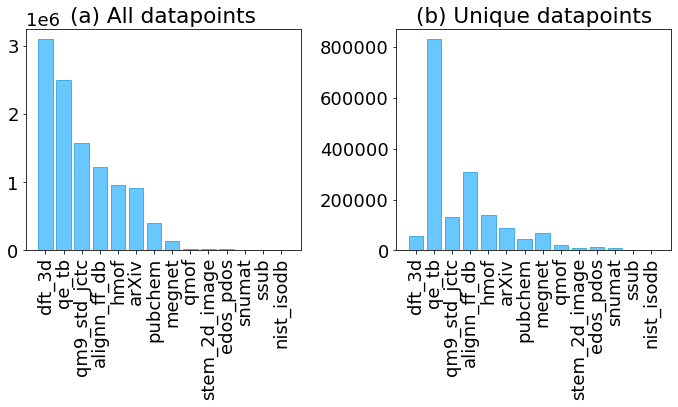

In [55]:
import numpy as np
names=[]
all_ids=[]
unique_ids=[]
for i,j in id_info.items():
    print (i,len(j),len(set(j)))
    names.append(i)
    all_ids.append(len(j))
    unique_ids.append(len(set(j)))
  

order=np.argsort(all_ids)[::-1]
names=np.array(names)[order]
all_ids=np.array(all_ids)[order]
unique_ids=np.array(unique_ids)[order]
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

the_grid = GridSpec(1, 2)
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,6))

plt.subplot(the_grid[0, 0])
plt.title('(a) All datapoints')
plt.bar(names,all_ids,facecolor = '#2ab0ff', edgecolor='#169acf',alpha=0.7)
plt.xticks(rotation=90)

plt.subplot(the_grid[0, 1])
plt.title('(b) Unique datapoints')
plt.bar(names,unique_ids,facecolor = '#2ab0ff', edgecolor='#169acf',alpha=0.7)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
# plt.savefig('data_dist.pdf')
# plt.close()

In [ ]:
from jarvis.db.figshare import data
#names=['dft_2d']
elements=[]
for i in names:
    print (i)
    try:
        dd=data(i)
        if 'atoms' in dd[0]:
            for j in dd:
                for k in j['atoms']['elements']:
                    elements.append(k)
    except:
        pass
            
    

dft_3d
Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
qe_tb
Obtaining QETB dataset 860k...
Reference:https://arxiv.org/abs/2112.11585
Loading the zipfile...
qm9_std_jctc
Obtaining QM9 standardized dataset 130k,From https://doi.org/10.1021/acs.jctc.7b00577,+
Reference:https://www.nature.com/articles/sdata201422
Loading the zipfile...


In [110]:
from collections import Counter
all_els = dict(Counter(elements))
total=np.array(list(all_els.values())).sum()
total

27315319

In [116]:
f=open('elements.csv','w')
for i,j in all_els.items():
    line=str(i)+' '+str(100*j/total)+'\n'
    f.write(line)

    #print (i,100*j/total)
f.close()

In [128]:
from jarvis.analysis.periodic.ptable import plot_ptable_trend
plot_ptable_trend(save_plot=False, input_file='elements.csv')

/home/kamalch/miniconda3/envs/gpaw/lib/python3.8/site-packages/jarvis/analysis/periodic/ptable.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elements.period[i] = "La"
/home/kamalch/miniconda3/envs/gpaw/lib/python3.8/site-packages/jarvis/analysis/periodic/ptable.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elements.group[i] = str(count + 4)
/home/kamalch/miniconda3/envs/gpaw/lib/python3.8/site-packages/jarvis/analysis/periodic/ptable.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Start : This command cannot be run due to the error: The system cannot find the file specified.
At line:1 char:1
+ Start "file:///mnt/c/Users/knc6/OneDrive - NIST/KamalLaptop/JARVIS-le ...
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : InvalidOperation: (:) [Start-Process], InvalidOperationException
    + FullyQualifiedErrorId : InvalidOperationException,Microsoft.PowerShell.Commands.StartProcessCommand
 


Figure(id='2904', ...)

In [118]:
!ls -altr

total 912
drwxrwxrwx 1 kamalch kamalch   4096 Apr 17 17:22 ..
-rwxrwxrwx 1 kamalch kamalch 843696 Apr 17 23:56 Paper-Copy1.ipynb
drwxrwxrwx 1 kamalch kamalch   4096 Apr 17 23:56 .ipynb_checkpoints
-rwxrwxrwx 1 kamalch kamalch   2015 Apr 18 00:25 elements.csv
-rwxrwxrwx 1 kamalch kamalch  14359 Apr 18 00:25 ptable.html
-rwxrwxrwx 1 kamalch kamalch  68485 Apr 18 00:25 DataSetPlot.ipynb
drwxrwxrwx 1 kamalch kamalch   4096 Apr 18 00:25 .


In [20]:

for i in glob.glob("jarvis_leaderboard/dataset/*/*/*.json.zip"):
    fname = i.split("/")[-1].split(".csv.zip")[0]
    dataset = fname
    

    print (dataset)
    break
    


stem_2d_image_bravais_class.json.zip


In [19]:
temp

['stem_2d_image_bravais_class.json.zip']

In [124]:
dff=pd.read_csv('tmp.csv')

In [125]:
dff

,Methods,SinglePropertyPrediction,SinglePropertyClass,MLFF,TextClass,ImageClass,Spectra,EigenSolver
0,AI,124,7,4,18,2,1,0
1,ES,501,0,0,0,0,10,0
2,FF,45,0,0,0,0,0,0
3,QC,0,0,0,0,0,0,1
4,EXP,0,0,0,0,0,6,0


In [126]:
fig = px.sunburst(dff, path=['AI', 'ES', 'FF'], values='SinglePropertyPrediction')
fig.show()

ValueError: Value of 'path_0' is not the name of a column in 'data_frame'. Expected one of ['Methods', 'SinglePropertyPrediction', 'SinglePropertyClass', 'MLFF', 'TextClass', 'ImageClass', 'Spectra', 'EigenSolver'] but received: AI

In [121]:
import plotly.express as px
import pandas as pd
vendors = ["A", "B", "C", "D", None, "E", "F", "G", "H", None]
sectors = ["Tech", "Tech", "Finance", "Finance", "Other",
           "Tech", "Tech", "Finance", "Finance", "Other"]
regions = ["North", "North", "North", "North", "North",
           "South", "South", "South", "South", "South"]


vendors=['AI','ES','FF','QC','EXP','AI','ES','FF','QC','EXP',]
sectors=['SPP','SPC','MLFF','TC','IC','Sp','EIS',None,None,None,None,None,None,None,]


sales = [124,7,4,18,2,1,0,501,0,0,0,0,10,0]# 1, 4, 1]
df = pd.DataFrame(
    dict(vendors=vendors, sectors=sectors, sales=sales)
)
print(df)
fig = px.sunburst(df, path=['sectors', 'vendors'], values='sales')
fig.show()

ValueError: arrays must all be same length